In [1]:
import deepxde as dde
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from naca4digit_airfoil import Naca4DigitAirfoil
from navier_stokes import NavierStokesPDEs
import utils

/Users/ggito/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
dde.config.set_random_seed(48)
dde.config.set_default_float('float64')

xmin_original, xmax_original = -2.5, 4
ymin_original, ymax_original = -2.5, 2.5

sf = max((xmax_original - xmin_original), (ymax_original - ymin_original))

rho  = 1.0
mu   = 0.02
u_in  = 1

Set the default float type to float64


In [3]:
airfoil = Naca4DigitAirfoil(c=1/sf, M=2, P=4, T=12, a=0, offset_x=0, offset_y=0)

In [4]:
xmin = xmin_original / sf
xmax = xmax_original / sf
ymin = ymin_original / sf
ymax = ymax_original / sf

In [5]:
# Geometry defintion
farfield = dde.geometry.Rectangle([xmin, ymin], [xmax, ymax])
airfoil_geom  = dde.geometry.Polygon(airfoil.get_boundary_points(250))
geom     = dde.geometry.CSGDifference(farfield, airfoil_geom)

inner_rec  = dde.geometry.Rectangle([-0.1, -0.1], [0.1, 0.1])
inner_dom  = dde.geometry.CSGDifference(inner_rec, airfoil_geom)

outer_dom  = dde.geometry.CSGDifference(farfield, inner_rec)
outer_dom  = dde.geometry.CSGDifference(outer_dom, airfoil_geom)

In [6]:
Nf1 = 2**15 # = 32768
Nf2 = 2**16 # = 65536
Nb  = 2**11 # = 2048
Ns  = 250

random = "Sobol"
inner_points = inner_dom.random_points(Nf1, random=random)
outer_points = outer_dom.random_points(Nf2, random=random)

farfield_points = farfield.random_boundary_points(Nb, random=random)
airfoil_points  = airfoil.get_boundary_points(Ns)

points = np.append(inner_points, outer_points, axis = 0)
points = np.append(points, farfield_points, axis = 0)
points = np.append(points, airfoil_points, axis = 0)

/Users/ggito/Library/Python/3.9/lib/python/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+32769=32769. 
  warnings.warn("The balance properties of Sobol' points require "
/Users/ggito/Library/Python/3.9/lib/python/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+65537=65537. 
  warnings.warn("The balance properties of Sobol' points require "
/Users/ggito/Library/Python/3.9/lib/python/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2051=2051. 
  warnings.warn("The balance properties of Sobol' points require "


(-0.38461538461538464, 0.38461538461538464)

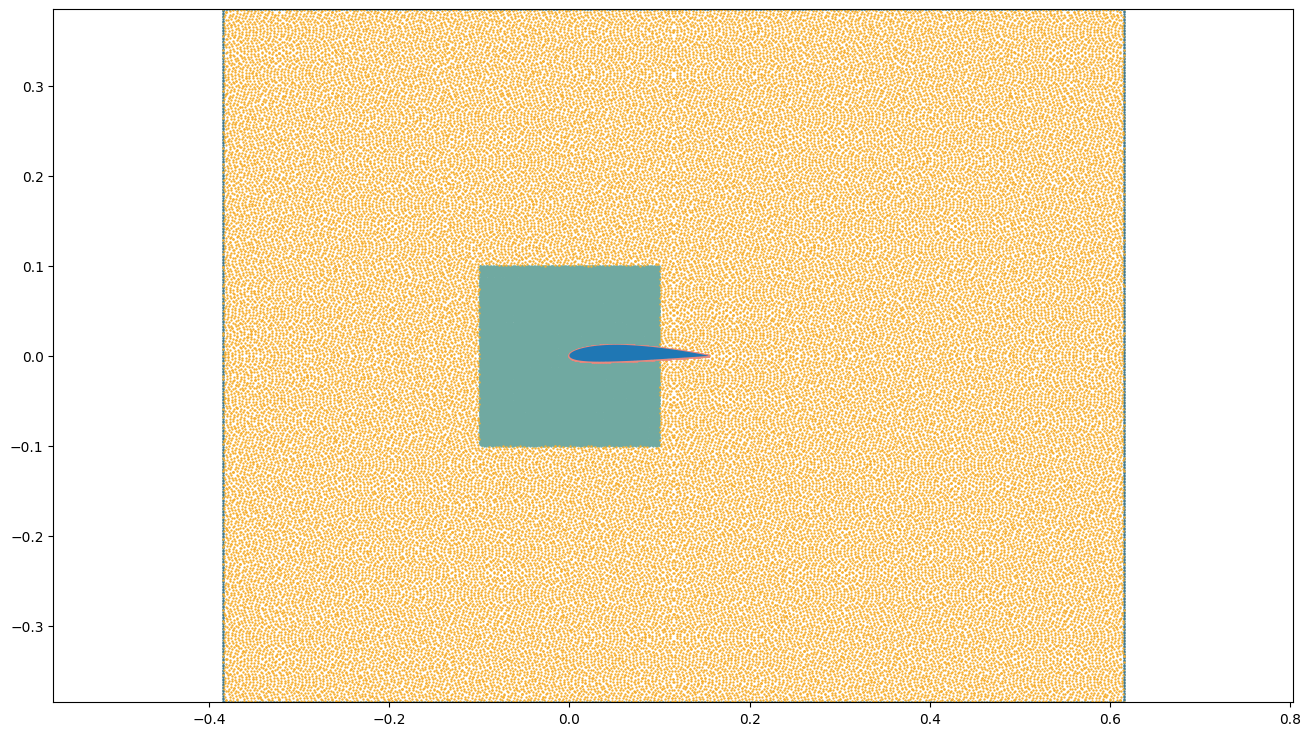

In [7]:
fig1, ax1 = plt.subplots(figsize = (16, 9))
plt.axis('equal')
plt.scatter(farfield_points[:, 0], farfield_points[:, 1], s = 0.5, c='#40798C')  # Ocean blue for farfield points
plt.scatter(inner_points[:, 0], inner_points[:, 1], s = 0.5, c = '#70A9A1')  # Soft seafoam for inner points
plt.scatter(outer_points[:, 0], outer_points[:, 1], s = 0.5, c = '#F6AE2D')  # Sunflower yellow for outer points
plt.scatter(airfoil_points[:, 0], airfoil_points[:, 1], s = 0.5, c = '#E9897E')  # Sunset coral for airfoil points
plt.fill(airfoil_points[:, 0], airfoil_points[:, 1])
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

In [8]:
navier_stokes_pdes = NavierStokesPDEs(rho=rho, mu=mu,
                                      xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
                                      airfoil_geom=airfoil_geom, geom=geom,
                                      u_farfield=u_in, v_farfield=0.0)

pdes_fun = navier_stokes_pdes.get_pdes
bcs = navier_stokes_pdes.get_bcs()

In [9]:
# Problem setup
# TODO: try samling
data = dde.data.PDE(geom, pdes_fun, bcs, num_domain = 0, num_boundary = 0, num_test = 5000, anchors = points)

dde.config.set_default_float('float64')

Set the default float type to float64


(-0.4346153846153846,
 0.6653846153846155,
 -0.42307692307692313,
 0.42307692307692313)

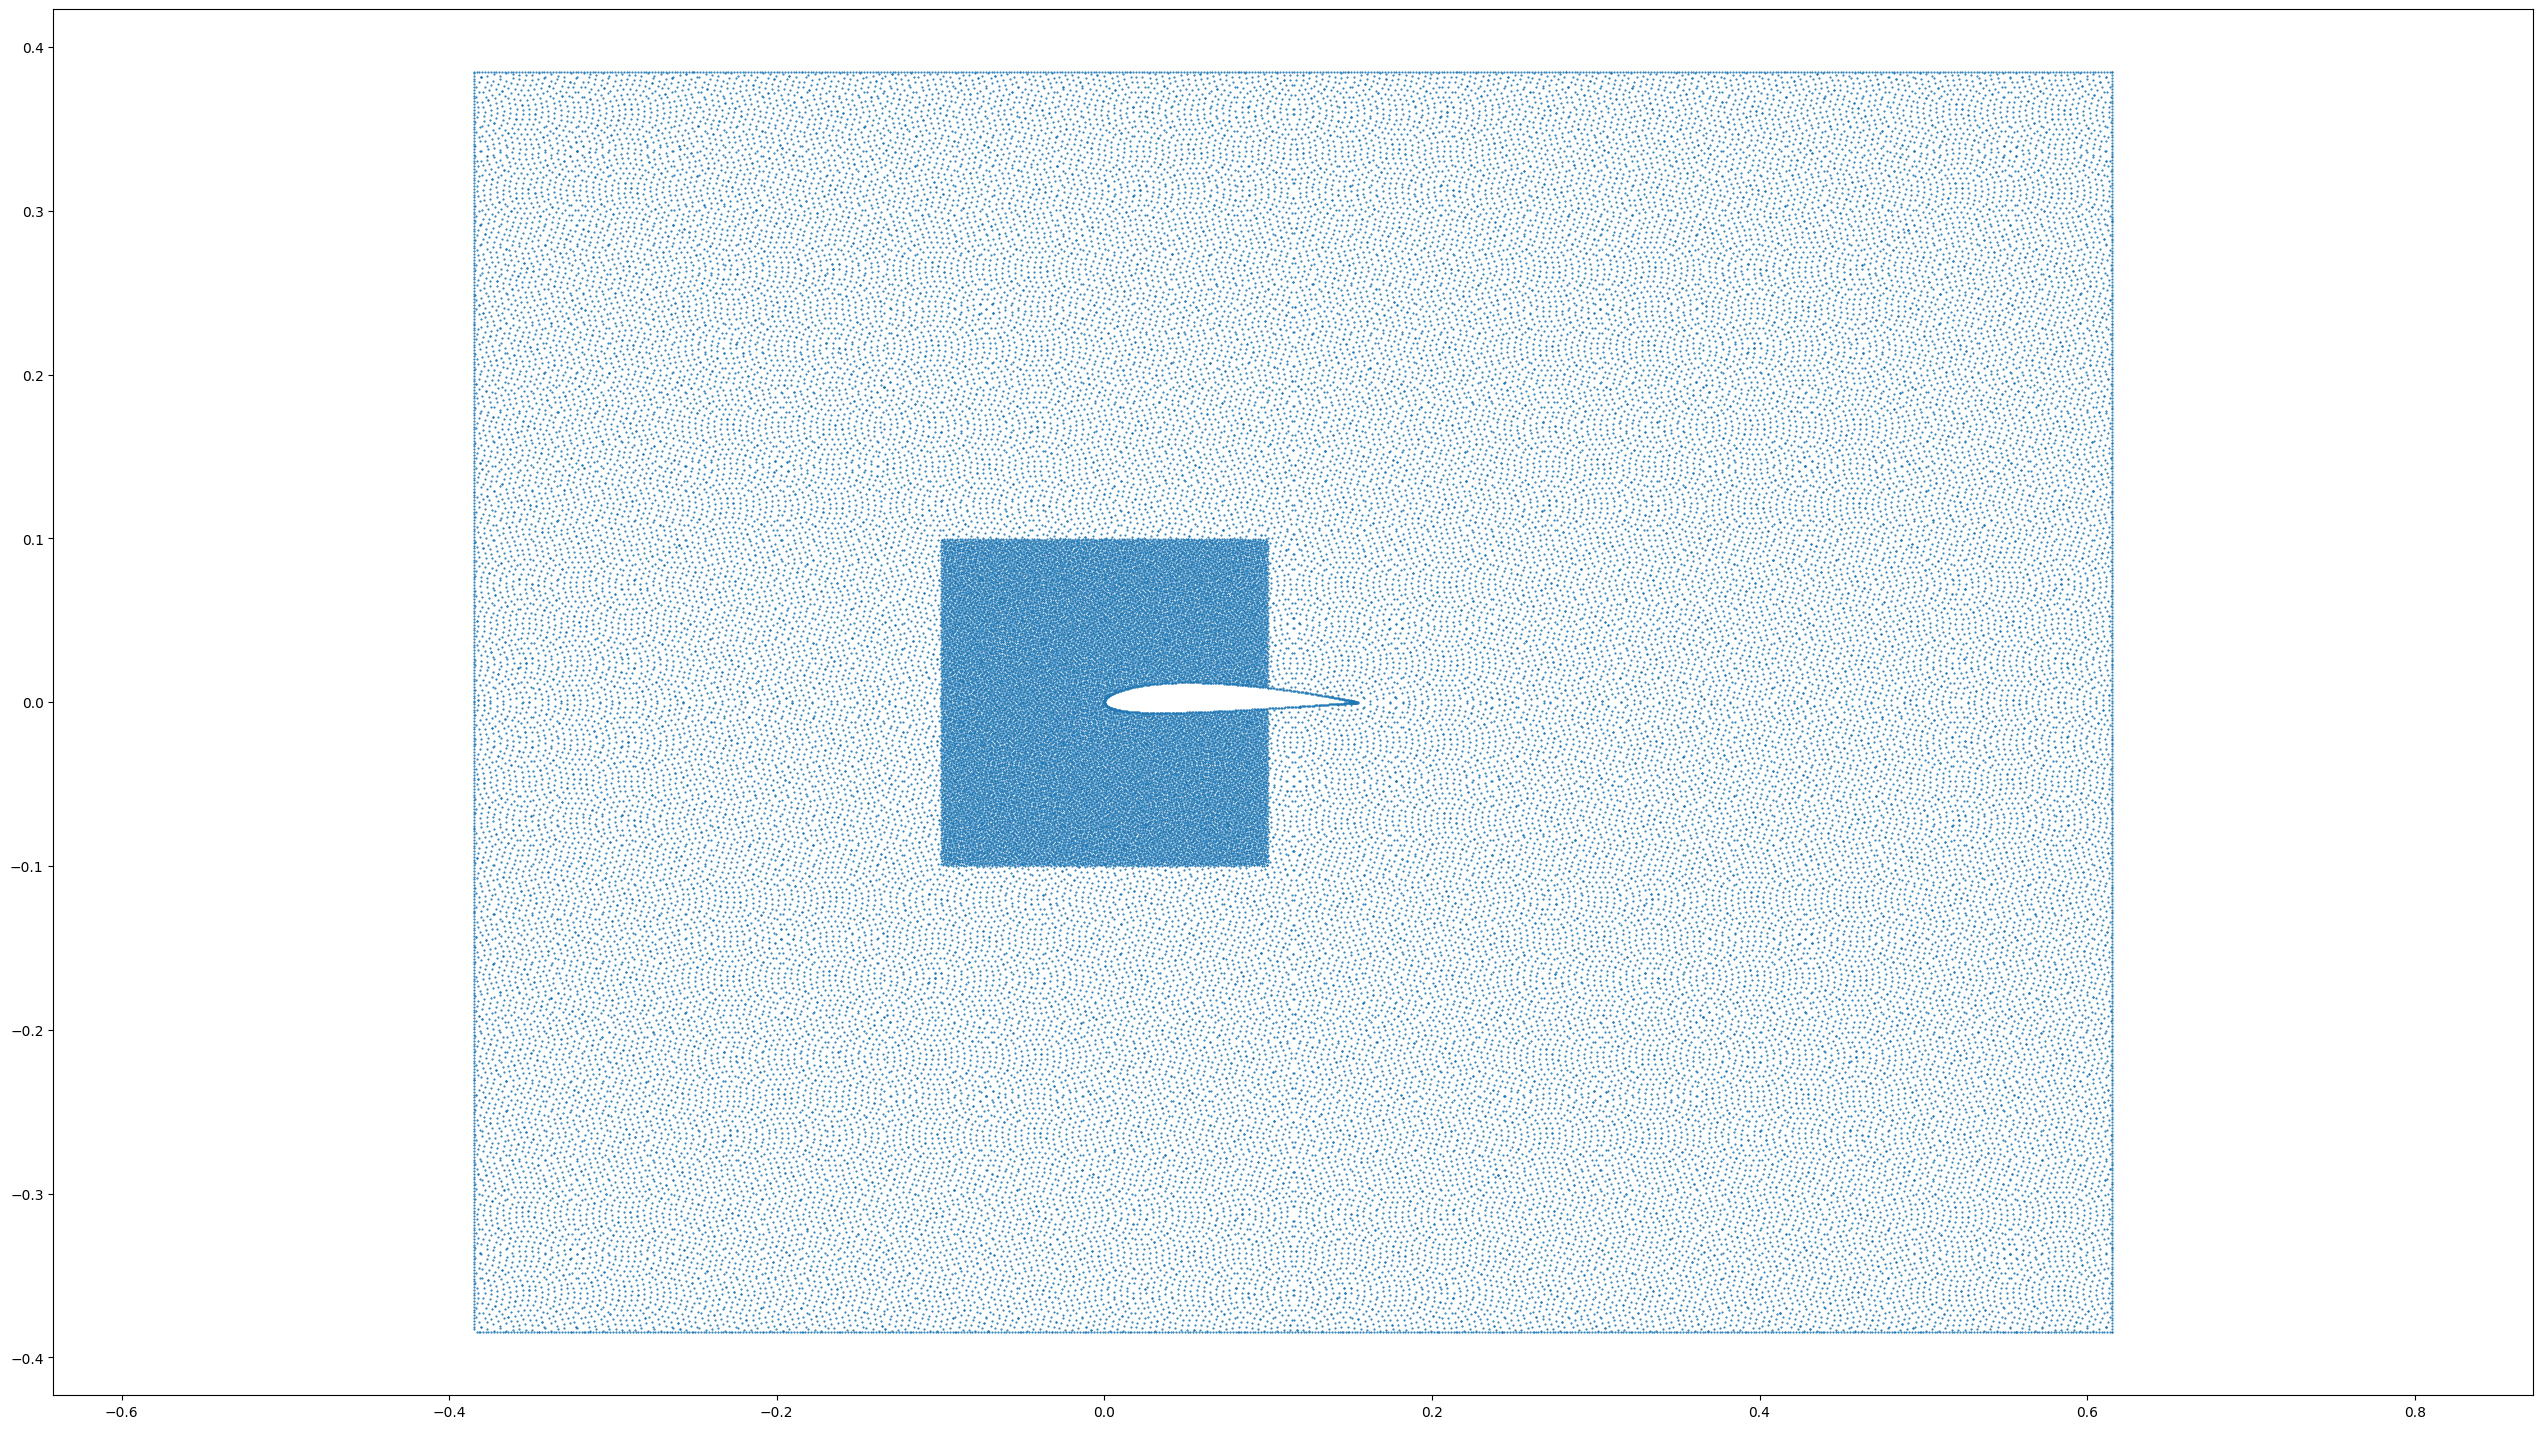

In [10]:
plt.figure(figsize = (32, 18))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.3)
plt.axis('equal')

In [11]:
# Neural network definition
layer_size  = [2] + [32] * 10 + [5]
activation  = 'tanh' 
initializer = 'Glorot uniform'

net = dde.nn.FNN(layer_size, activation, initializer)

# Model definition
model = dde.Model(data, net)

In [12]:
name_generator = utils.NameGenerator()
model_name = name_generator.generate_name()
model_name

'GustAnalyticNebula561'

In [13]:
# model.compile(optimizer = 'adam', lr = 5e-4, loss_weights = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]) # Giving more weight to bcs
model.compile(optimizer = 'adam', lr = 5e-4, loss_weights = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]) # Giving more weight to bcs

Compiling model...
'compile' took 0.003000 s



In [ ]:
try:
  losshistory, train_state = model.train(epochs = 10000, display_every = 100, model_save_path = './' + model_name + '/')
  dde.saveplot(losshistory, train_state, issave = True, isplot = True)

except KeyboardInterrupt:
  print(f"Training stopped by user.")
  print("=======================================================")

In [ ]:
# model.compile(optimizer = 'L-BFGS-B', loss_weights = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])
# model.train_step.optimizer_kwargs = {'options': {'maxcor': 50, 
#                                                    'ftol': 1.0 * np.finfo(float).eps, 
#                                                    'maxfun':  50000, 
#                                                    'maxiter': 50000, 
#                                                    'maxls': 50}}
#
# losshistory, train_state = model.train(display_every = 1, model_save_path = './')
# dde.saveplot(losshistory, train_state, issave = True, isplot = True)

In [ ]:
# model.restore('./-10000.ckpt.index')

In [ ]:
# Plotting tool: thanks to @q769855234 code snippet
dx = 0.01
dy = 0.01
x = np.arange(xmin, xmax + dy, dx)
y = np.arange(ymin, ymax + dy, dy)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

In [ ]:
# Model predictions generation
u = model.predict(X, operator = navier_stokes_pdes.getU)
v = model.predict(X, operator = navier_stokes_pdes.getV)
p = model.predict(X, operator = navier_stokes_pdes.getP)

for i in range(len(X)):
   if airfoil_geom.inside(np.array([X[i]]))[0]:
       u[i] = 0.0
       v[i] = 0.0

u = u.reshape(len(y), len(x))
v = v.reshape(len(y), len(x))
p = p.reshape(len(y), len(x))

airfoil_plot = airfoil.get_boundary_points(150)

fig1, ax1 = plt.subplots(figsize = (16, 9))
#ax1.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(p.min(), p.max(), 0.001)
cnt1 = ax1.contourf(x, y, p, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig1.colorbar(cnt1)
plt.savefig(model_name + '/NACA0012NS0.png')

fig2, ax2 = plt.subplots(figsize = (16, 9))
ax2.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(u.min(), u.max(), 0.001)
cnt2 = ax2.contourf(x, y, u, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig2.colorbar(cnt2)
plt.savefig(model_name + '/NACA0012NS1.png')

fig3, ax3 = plt.subplots(figsize = (16, 9))
ax3.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(v.min(), v.max(), 0.001)
cnt3 = ax3.contourf(x, y, v, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig3.colorbar(cnt3)
plt.savefig(model_name + '/NACA0012NS2.png')